# Using Selection by Geography

In [1]:
import transportation_tutorials as tt
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
from shapely.geometry import Polygon

## Questions

Consider a study area that mostly covers Deerfield Beach in Florida. 
The study area can be defined by a polygon bounded by the following 
coordinates (given in `epsg:4326`):

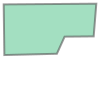

In [2]:
Polygon([
    (-80.170862, 26.328588),
    (-80.170158, 26.273494),
    (-80.113007, 26.274882),
    (-80.104592, 26.293503),
    (-80.072967, 26.293790),
    (-80.070111, 26.329349)
])

1. Use OSMnx to download the boundaries for Deerfield Beach, and generate
   an image that compares the city to the indicated study area polygon. Are 
   there any areas in the city of Deerfield Beach that are outside the
   designated studay area, and if so, is this concerning? *(Hint: use the
   `add_basemap` function from the `transportation_tutorials.mapping` package
   to add context to your map.)*
2. How many MAZs are there that are located completely inside the study area? 
   Generate a static map of only these MAZ's.  *(Hint: Please make sure to use 
   appropriate Coordinate Reference Systems (CRS) in your analysis.)*
3. How many MAZs are at least partially inside the study area?  Generate a static map 
   of these MAZ's, including the full area of any MAZ that is at least partially 
   contained in the study area.

## Data

To answer the questions, use the following file:

In [3]:
maz = gpd.read_file(tt.data('SERPM8-MAZSHAPE'))

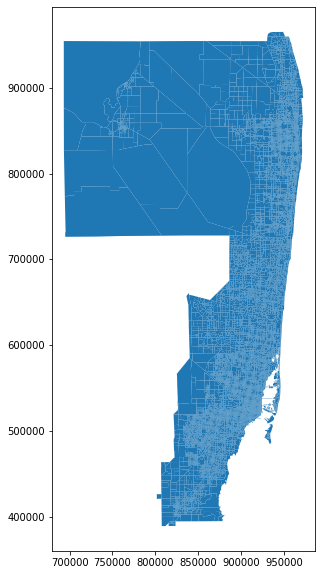

In [4]:
maz.plot(figsize = (10,10));

In [5]:
maz.head()

,OBJECTID,MAZ,SHAPE_LENG,SHAPE_AREA,ACRES,POINT_X,POINT_Y,geometry
0,1,5347,8589.393674,3.111034e+06,71,953130,724165,"POLYGON ((953970.4660769962 723936.0810402408,..."
1,2,5348,11974.067469,7.628753e+06,175,907018,634551,"POLYGON ((908505.2801046632 635081.7738410756,..."
2,3,5349,9446.131753,4.007041e+06,92,923725,707062,"POLYGON ((922736.6374686621 708387.6918614879,..."
3,4,5350,21773.153739,2.487397e+07,571,908988,713484,"POLYGON ((908334.2374677472 715692.2628822401,..."
4,5,5351,17882.701416,1.963139e+07,451,909221,717493,"POLYGON ((911883.0187559947 719309.3261861578,..."


## Solution

First, we create a variable from the defined polygon for our study area. 
The coordinates are given in `epsg:4326` format, which is the same as the 
coordinate system used by OpenStreetMaps, so we do not yet need to convert
our data.

In [6]:
clipper_poly = Polygon([
    (-80.170862, 26.328588),
    (-80.170158, 26.273494),
    (-80.113007, 26.274882),
    (-80.104592, 26.293503),
    (-80.072967, 26.293790),
    (-80.070111, 26.329349)
])

Then, we can download the Deerfield Beach data from OpenStreetMap:

In [7]:
city = ox.gdf_from_place('Deerfield Beach, Florida, USA')

And plot them together:

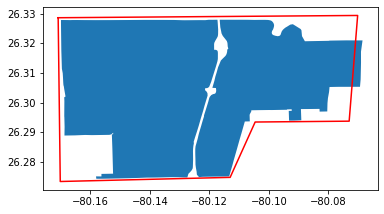

In [8]:
ax = city.plot()
lines = ax.plot(*clipper_poly.exterior.xy, color = 'r')

The shape we received from OpenStreetMap does indeed have some area outside
the study area polygon.  To identify whether we should be concerned, it
will be useful to have some context about what exactly is in that region.
We can use the `add_basemap` function to attach some map tiles to our
map that will give us the necessary context:

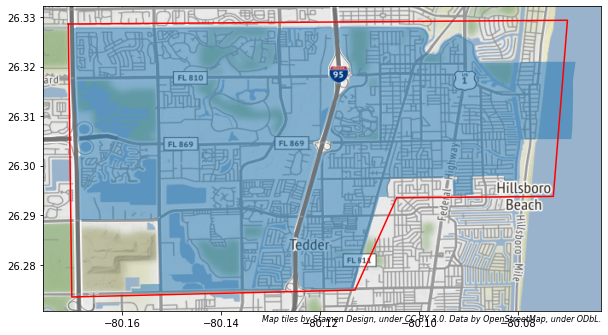

In [9]:
ax = city.plot(alpha=0.5)
lines = ax.plot(*clipper_poly.exterior.xy, color = 'r')
ax = tt.mapping.add_basemap(ax, zoom=13, epsg=4326)

Looks like that part of Deerfield Beach from OSM that's not in our study area 
is out in the Atlantic Ocean.  We've not going to be studying boaters today,
so we can safely ignore this discrepancy.

To evaluate the MAZ's relative to the study area, we'll use the provided MAZ 
shapefile data.  We can check the coordinate reference system used for this 
data:

In [10]:
maz.crs

{'init': 'epsg:2236'}

And we find that it is *not* the same as the other data available, which is in
EPSG:4326. We can use GeoPandas to reformat the study area polygon
to be in the same crs as the MAZ data like this:

In [11]:
clipper_gdf = gpd.GeoDataFrame(index=[0], crs={'init': 'epsg:4326'}, geometry=[clipper_poly]).to_crs(epsg=2236)
clipper_poly = clipper_gdf.geometry[0]

Or, we could change the MAZ data to match the crs of the study area:

In [12]:
maz_4326 = maz.to_crs(epsg = 4326)

For this work, we'll stick with the former, as 
[EPSG:2236](https://epsg.io/2236) is better suited
to reduce distortion on map renders in Florida.
We can plot the study area polygon over MAZs to see the 
location of study area within the region.

NameError: name 'clipper' is not defined

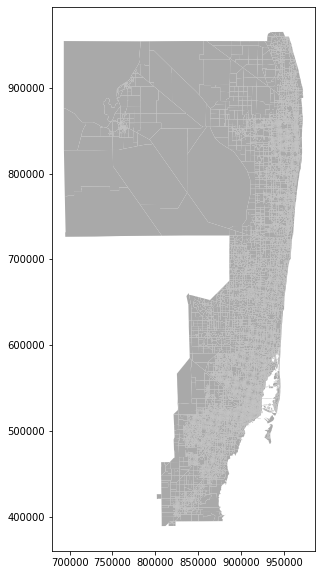

In [13]:
ax = maz.plot(figsize = (10,10), color = 'darkgrey')
clipper.plot(ax=ax);

To render just the study area and the MAZs that fall completely 
inside the study area, we use `.within()` method as boolean mask 
for selection.

In [ ]:
maz_within = maz[maz.within(clipper.geometry[0])]
ax = maz_within.plot(figsize = (10,10), color = 'grey', edgecolor = 'w')
clipper.plot(ax=ax, color='none', edgecolor = 'r');

Now, we can use `maz_within` dataframe to find our answer to the first question. 

In [ ]:
print('There are {} MAZs inside the study area.'.format(maz_within.shape[0]))

To instead include all the MAZ's that touch the study area polygon,
including those that are partially outside it, we can repeat the 
same code using `intersects` instead of `within`.

In [ ]:
maz_intersects = maz[maz.intersects(clipper_poly)]
ax = maz_intersects.plot(
    figsize = (10,10), 
    color = 'grey', 
    edgecolor = 'w'
)
clipper.plot(ax=ax, color='none', edgecolor = 'r');

In [ ]:
print('There are {} MAZs at least partially inside the study area.'.format(maz_intersects.shape[0]))